In [1]:
#!/usr/bin/env python
# import analyzer
import importlib
from importlib import reload
import os, sys, glob, warnings, glob
import numpy as np
import scipy as sp
import joblib
# from tqdm.notebook import tqdm
from tqdm import tqdm
import ROOT as root
from pylab import *

import iminuit
from iminuit import Minuit, cost

import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

Welcome to JupyROOT 6.24/06


In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector, Kalman_tom
import visualization as vis
import cutflow,detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(Kalman_tom)

<module 'Kalman_tom' from '/project/6035200/tomren/jupyter/tracker_analysis/Kalman_tom.py'>


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



# Fit methods comparison

1. LS fit, with (x0,t0,z0,vx,vy,vz) as parameters
2. Kalman filter, with (vx,vy,vz) as parameters, Q=0
3. Kalman filter, with (x0,t0,z0,vx,vy,vz) as parameters, Q=0
4. Kalman filter, with (vx,vy,vz) as parameters, Q from multiple scattering (**Current MATHUSLA implementation**)
5. Kalman filter, with (x0,t0,z0,vx,vy,vz) as parameters, Q from multiple scattering

1 and 4 should be equal mathmatically

In [3]:
# Tree=ev.Tree
# barnches = Tree.GetListOfBranches()
# nevents = int(Tree.GetEntries())
# branch_list = [barnches[i].GetName() for i in range(len(barnches))]
# print(branch_list)

In [4]:
# Data preparation:
# get all tracks that have 7 hits (one hit per layer)
cut=cutflow.sample_space("")

def get_digi_hits(ev):
    ev.Tree.GetEntry(ev.EventNumber)
    hits=[]
    for ii in range(len(ev.Tree.Digi_y)):
        hit=Hit(ev.Tree.Digi_x[ii], ev.Tree.Digi_y[ii], ev.Tree.Digi_z[ii], ev.Tree.Digi_time[ii])
        hit.get_uncertainty()
        hits.append(hit)
    return hits

def get_event_truth(ev):
    ev.Tree.GetEntry(ev.EventNumber)
    dx=ev.Tree.Hit_x[1]-ev.Tree.Hit_x[0]
    dy=ev.Tree.Hit_y[1]-ev.Tree.Hit_y[0]
    dz=ev.Tree.Hit_z[1]-ev.Tree.Hit_z[0]
    dt=ev.Tree.Hit_time[1]-ev.Tree.Hit_time[0]
    truth=[ev.Tree.Hit_x[0], ev.Tree.Hit_y[0], ev.Tree.Hit_z[0], ev.Tree.Hit_time[0],dx/dt, dy/dt, dz/dt]
    return truth

class Hit:
    def __init__(self, x, y, z, t):
        self.x=x
        self.y=y
        self.z=z
        self.t=t
        self.t_uncertainty=1
    def get_uncertainty(self):
        # Get the layer-dependent uncertainty of each hit
        self.hit_layer=cut.in_layer(self.y)
        hit_uncertainty = np.array(detector.Layer().uncertainty(self.hit_layer))
        self.x_uncertainty=hit_uncertainty[0]*100 # m->cm
        self.y_uncertainty=hit_uncertainty[1]*100 # m->cm
        self.z_uncertainty=hit_uncertainty[2]*100 # m->cm
#         self.y_uncertainty=2/np.sqrt(12)


In [6]:
# Pull hits from simulation

muon_energy=1000
print("Processing energy ",muon_energy, "GeV")

data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/muon_{muon_energy}_GeV_manual/*/*/stat0.root",)
files=util.Utils.sortByExt(files)

Hit_collection = []
Truth_collection = []
hit_inds=[]
for i_file in tqdm(range(len(files))):
# for i_file in tqdm(range(10)):
    filename=files[i_file]
    tree_name="integral_tree"
    ev = event.Event(filename, 0, tree_name=tree_name)
    nevents = int(ev.Tree.GetEntries())

    for i_event in range(nevents):
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)
        if len(ev.Tree.Digi_x)==7:
            hit_inds.append(i_event)
            hits = get_digi_hits(ev)
            truth =  get_event_truth(ev)
            
            Hit_collection.append(hits)
            Truth_collection.append(truth)

Processing energy  1000 GeV


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


## 1. Define LS fit

In [8]:
# -------------------------------------
# LS fit
# ------------------------------------
class chi2_track:
    def __init__(self, hits):
        self.hits=hits
        self.func_code = iminuit.util.make_func_code(['x0', 'y0', 'z0', 't0', 'vx', 'vy', 'vz'])
    def __call__(self, x0, y0, z0, t0, vx, vy, vz):
        error=0
        for hit in self.hits:
            model_t = (hit.y - y0)/vy
            model_x = x0 + model_t*vx
            model_z = z0 + model_t*vz
            error+= np.sum(np.power([(model_t- (hit.t-t0))/hit.t_uncertainty, 
                                     (model_x-hit.x)/hit.x_uncertainty, 
                                     (model_z-hit.z)/hit.z_uncertainty],2))
        return error        

def guess_track(hits):
    # Guess initial value
    x0_init = hits[0].x
    y0_init = hits[0].y
    z0_init = hits[0].z
    t0_init = hits[0].t
    dt=hits[1].t-hits[0].t
    vx_init = (hits[1].x-hits[0].x)/dt
    vy_init = (hits[1].y-hits[0].y)/dt
    vz_init = (hits[1].z-hits[0].z)/dt
    v_mod = np.sqrt(vx_init**2+vy_init**2+vz_init**2)
    if v_mod>sp.constants.c*1e-7:
        vx_init = vx_init*0.99*sp.constants.c*1e-7/v_mod
        vy_init = vy_init*0.99*sp.constants.c*1e-7/v_mod
        vz_init = vz_init*0.99*sp.constants.c*1e-7/v_mod
    return  (x0_init,y0_init, z0_init,t0_init,vx_init,vy_init,vz_init)
    
def fit_track(hits, guess):
    x0_init,y0_init, z0_init,t0_init,vx_init,vy_init,vz_init = guess
    det=detector.Detector()

    m = Minuit(chi2_track(hits),x0=x0_init, y0=y0_init, z0=z0_init, t0=t0_init, vx=vx_init, vy=vy_init, vz=vz_init)
    m.fixed["y0"]=True
    m.limits["x0"]=(det.BoxLimits[0][0],det.BoxLimits[0][1])
    m.limits["z0"]=(det.BoxLimits[2][0],det.BoxLimits[2][1])
    m.limits["t0"]=(0,1e5)
    m.limits["vx"]=(-sp.constants.c*1e-7, sp.constants.c*1e-7) # Other
    m.limits["vy"]=(-sp.constants.c*1e-7*2,0) if vy_init<0 else (0,sp.constants.c*1e-7*2) # Constrain the direction in Z(up) in real world
    m.limits["vz"]=(-sp.constants.c*1e-7, sp.constants.c*1e-7) # Beam direction; From MKS unit to cm/ns = 1e2/1e9=1e-7
    m.errors["x0"]=0.1
    m.errors["y0"]=0.1
    m.errors["z0"]=0.1
    m.errors["t0"]=0.3
    m.errors["vx"] = 0.01
    m.errors["vy"] = 0.1
    m.errors["vz"] = 0.01

    m.migrad()  # run optimiser
    m.hesse()   # run covariance estimator
    
    return m

## Define Kalman filter, 3 parameters, Q=3

In [16]:
# ----------------------------------------------------------------------
def Seed(hits):
#     c=sp.constants.c/1e7
    c=29.97
    seeds=[]
    for i in range(len(hits)):
        for j in range(i+1, len(hits)):
            dx = hits[i].x- hits[j].x
            dy = hits[i].y- hits[j].y
            dz = hits[i].z- hits[j].z
            dt = hits[i].t- hits[j].t
            ds = np.abs((dx**2+dy**2-dz**2)/c**2-dt**2)
#             print(i,j, ds)
#             print(hits[i].x, hits[i].z,hits[j].x, hits[j].z)
            if ds>5:
                continue
                
#             seeds.append([hits[i],hits[j]])
            seeds.append([i,j,ds])
    return np.array(seeds)

def init_state(hits):
    score = Seed(hits)
    ind=np.argmin(score[:,2])
#     ind=0
    i=int(score[ind][0])
    j=int(score[ind][1])
#     print(i,j)
    i=0
    j=1
    
    dt=hits[j].t-hits[i].t
    dx=hits[j].x-hits[i].x
    dy=hits[j].y-hits[i].y
    dz=hits[j].z-hits[i].z
    
#     print(dx,dy,dz,dt)
    
    # Initial State Vector: X0
    X0 = np.array([hits[0].x, hits[0].t, hits[0].z, dx/dt, dy/dt, dz/dt])
#     X0 = np.array([hits[1].x, hits[1].t, hits[1].z, dx/dt, dy/dt, dz/dt])
    
    # Initial Variance P0
    J =np.array([[ 1      , 0           , 0       , 0       , 0       , 0             , 0     , 0     ],
        [ 0       , 1           , 0       , 0       , 0       , 0             , 0     , 0     ],
        [ 0       , 0           , 1       , 0       , 0       , 0             , 0     , 0     ],
        [- 1 / dt, dx / (dt*dt), 0       , 0       , 1 / dt  , - dx / (dt*dt), 0     , 0     ],
        [0       , dy / (dt*dt), 0       , - 1 / dt, 0       , - dy / (dt*dt), 0     , 1 / dt],
        [0       , dz / (dt*dt), - 1 / dt, 0       , 0       , - dz / (dt*dt), 1 / dt, 0     ]])
#     # Initial Variance P0
#     J =np.array([[ 0      , 0           , 0       , 0       , 1       , 0             , 0     , 0     ],
#                 [ 0       , 0           , 0       , 0       , 0       , 1             , 0     , 0     ],
#                 [ 0       , 0           , 0       , 0       , 0       , 0             , 1     , 0     ],
#                 [- 1 / dt, dx / (dt*dt), 0       , 0       , 1 / dt  , - dx / (dt*dt), 0     , 0     ],
#                 [0       , dy / (dt*dt), 0       , - 1 / dt, 0       , - dy / (dt*dt), 0     , 1 / dt],
#                 [0       , dz / (dt*dt), - 1 / dt, 0       , 0       , - dz / (dt*dt), 1 / dt, 0     ]])
    err0=np.diag([hits[i].x_uncertainty,hits[i].t_uncertainty,hits[i].z_uncertainty,hits[i].y_uncertainty,
                 hits[j].x_uncertainty,hits[j].t_uncertainty,hits[j].z_uncertainty,hits[j].y_uncertainty])**2
    P0=J.dot(err0).dot(J.T)
    
#     P0=np.diag(np.ones(6)*1e10)
    
    return X0, P0

def init_state_LS(hits,x0,x0_cov):
    # Initial State Vector: X0
    X0 = np.array([x0[0], x0[2], x0[2], x0[3], x0[4], x0[5]])
    P0=x0_cov
    
    return X0, P0

def add_measurement(hit, X_current, dy):
    vy_current = X_current[4]
    dt_next = dy/vy_current
    Y = np.array([hit.x,hit.t,hit.z])
    R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
    A = np.array([[1, 0, 0, dt_next, 0, 0],
                  [0, 1, 0, 0, dt_next/vy_current, 0],
                  [0, 0, 1, 0, 0, dt_next],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])
    return  Y,R,A


def fit_kf_1(hits, init_truth=None):
    # Initial state (X0), covariance (P0), measurement (X0)
    if init_truth is None:
        X0,P0 = init_state(hits)
    else:
        X0,P0 = init_state_LS(hits,*init_truth)
        
    print(X0,P0)
        
    M0=X0[:3]
    # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
    H = np.array(\
        [[1,0,0,0,0,0],
         [0,1,0,0,0,0],
         [0,0,1,0,0,0]])
    # Initial propogation covariacne (Q)
    Q=0

    # Kalman Filter Object
    kf = Kalman_tom.KalmanFilter(X0,P0,M0,H=H)

    # Filter forward
    for i in range(1,7):
        hit = hits[i]
        dy = hits[i].y-hits[i-1].y

        X_previous = kf.X_filtered[-1]
        M_current,R,A = add_measurement(hit, X_previous, dy)
        kf.predict_foward(A,Q)
        kf.filter_forward(M_current,R)
        

    # Filter backward
    X_smoothed, p = kf.filter_backward()
    
    return kf

In [26]:
reload(Kalman_tom)

<module 'Kalman_tom' from '/project/6035200/tomren/jupyter/tracker_analysis/Kalman_tom.py'>

In [20]:
def fit_kf_1(hits, init_truth=None):
    # Initial state (X0), covariance (P0), measurement (X0)
    if init_truth is None:
        X0,P0 = init_state(hits)
    else:
#         X0,P0 = init_state_LS(hits,*init_truth)
        X0,P0=init_truth
        
    print(X0,P0)
        
    M0=X0[:3]
    # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
    H = np.array(\
        [[1,0,0,0,0,0],
         [0,1,0,0,0,0],
         [0,0,1,0,0,0]])
    # Initial propogation covariacne (Q)
    Q=0

    # Kalman Filter Object
    kf = Kalman_tom.KalmanFilter(X0,P0,M0,H=H)

    # Filter forward
    for i in range(1,7):
        hit = hits[i]
        dy = hits[i].y-hits[i-1].y

        X_previous = kf.X_filtered[-1]
        M_current,R,A = add_measurement(hit, X_previous, dy)
        kf.predict_foward(A,Q)
        kf.filter_forward(M_current,R)
        print("X0_f:",kf.X_filtered[-1])
        print("Pf:",kf.P_filtered[-1])

    # Filter backward
    X_smoothed, p = kf.filter_backward()
    
    return kf

In [21]:
X0 = np.array([430.391,7.98118, 12488.2,-2.62189, 29.3818, 5.96784,])
P0=np.array([[1.6875,          0,          0, -0.0702292,          0,          0,],
[         0,          1,          0,  -0.109116,    1.22279,   0.248365],
[         0,          0,      199.6,          0,          0,   -8.30682],
[-0.0702292,  -0.109116,          0,  0.0296581,  -0.266852, -0.0542013],
[         0,    1.22279,          0,  -0.266852,    2.99159,   0.607398],
[         0,   0.248365,   -8.30682, -0.0542013,   0.607398,   0.814786]])

[ 4.30391e+02  7.98118e+00  1.24882e+04 -2.62189e+00  2.93818e+01
  5.96784e+00] [[ 1.68750e+00  0.00000e+00  0.00000e+00 -7.02292e-02  0.00000e+00
   0.00000e+00]
 [ 0.00000e+00  1.00000e+00  0.00000e+00 -1.09116e-01  1.22279e+00
   2.48365e-01]
 [ 0.00000e+00  0.00000e+00  1.99600e+02  0.00000e+00  0.00000e+00
  -8.30682e+00]
 [-7.02292e-02 -1.09116e-01  0.00000e+00  2.96581e-02 -2.66852e-01
  -5.42013e-02]
 [ 0.00000e+00  1.22279e+00  0.00000e+00 -2.66852e-01  2.99159e+00
   6.07398e-01]
 [ 0.00000e+00  2.48365e-01 -8.30682e+00 -5.42013e-02  6.07398e-01
   8.14786e-01]]
X0_f: [ 4.23357504e+02  1.09894425e+01  1.24951773e+04 -2.58929132e+00
  2.82262882e+01  6.24821926e+00]
Pf: [[ 7.81170628e-01 -1.13370827e-01 -1.30969478e-01  2.01617701e-03
  -3.21934977e-01 -6.92504456e-02]
 [-1.13370827e-01  5.56775416e-01  2.58118130e-01 -5.99621801e-02
   6.34571379e-01  1.36480619e-01]
 [-1.30969478e-01  2.58118130e-01  8.59148090e+01 -6.92701609e-02
   7.32970615e-01 -3.20344033e+00]
 [ 2.016

/tmp/ipykernel_26261/4096381640.py:56: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()  # run optimiser


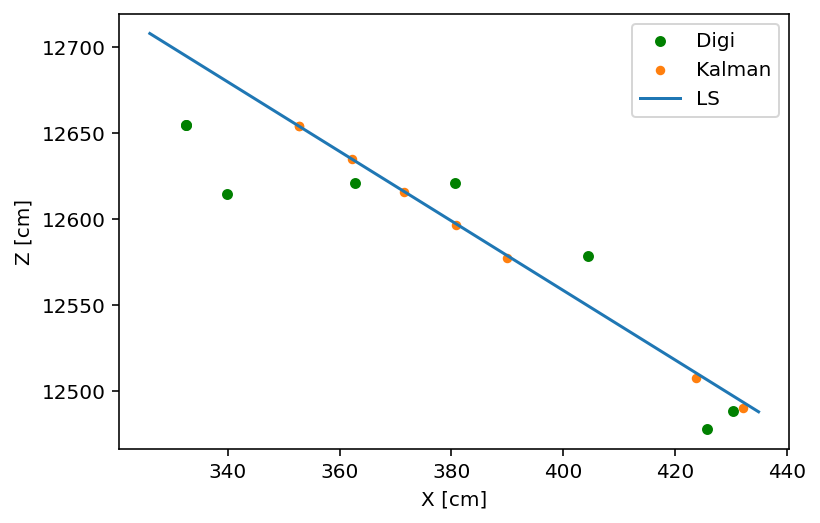

In [22]:
# # Turth
# dt=hits_truth[1][3]-hits_truth[0][3]
# dx=hits_truth[1][0]-hits_truth[0][0]
# dy=hits_truth[1][1]-hits_truth[0][1]
# dz=hits_truth[1][2]-hits_truth[0][2]
# X0_truth = np.array([hits_truth[0][0], hits_truth[0][3], hits_truth[0][2], dx/dt, dy/dt, dz/dt])
# # Xlast_truth = np.array([hits_truth[-1][0], hits_truth[-1][3], hits_truth[-1][2], dx/dt, dy/dt, dz/dt])
# # print(Xlast_truth)
# # print(kf.X_filtered[-1])


# Get one event
ievent=0
# ievent+=1
hits=Hit_collection[ievent]
truth=Truth_collection[ievent]

# Run fits
# 1. LS
guess=guess_track(hits)
fit1=fit_track(hits,guess)
#print(fit1)
# 2. Kalman, 3 par, Q=0
values=list(fit1.values)
del values[1]
a=np.array(fit1.covariance.tolist())
a=np.delete(a,1,0)
a=np.delete(a,1,1)
errors=a
init_truth = [values,errors]
# kf1=fit_kf_1(hits,init_truth=init_truth)  
kf1=fit_kf_1(hits,init_truth=(X0,P0))  
# print(kf1.X_smoothed[0])


# Plot digitized and Kalman
for i in range(7):
    scatter(hits[i].x, hits[i].z,color="g",s=20)    
#     scatter(kf2.X_filtered[i][0], kf2.X_filtered[i][2],color="C0",s=14)
    scatter(kf1.X_smoothed[i][0], kf1.X_smoothed[i][2],color="C1",s=14)
#     scatter(kf2.X_smoothed[i][0], kf2.X_smoothed[i][2],color="C3",s=14)    
scatter(hits[i].x, hits[i].z,color="g",s=20,label="Digi")    
# scatter(kf1.X_filtered[i][0], kf1.X_filtered[i][2],color="C0",s=14,label="Kalman, predict ")    
scatter(kf1.X_smoothed[i][0], kf1.X_smoothed[i][2],color="C1",s=14,label="Kalman")    
# scatter(kf2.X_smoothed[i][0], kf2.X_smoothed[i][2],color="C3",s=14,label="Kalman, v_init=LS")    


# Plot LS
fit1_res = list(fit1.values)
tlist = np.linspace(0,1000/25,10)
x_plot = fit1_res[0]+fit1_res[4]*tlist
z_plot = fit1_res[2]+fit1_res[6]*tlist
plot(x_plot,z_plot,label="LS")

# Plot Truth
# hits_truth=np.array(hits_truth)
# scatter(hits_truth[:,0],hits_truth[:,2],s=10,color="k",label="Truth")

# x_plot = truth[0]+truth[4]*tlist
# z_plot = truth[2]+truth[6]*tlist
# plot(x_plot,z_plot,label="Truth",color="r",linestyle=":")
# scatter(truth[0],truth[2],marker="*",color="r")


xlabel("X [cm]")
ylabel("Z [cm]")
legend()

In [28]:
for hit in hits:
    print(hit.x_uncertainty)

14.13235200002555
1.299038105676658
14.13235200002555
1.299038105676658
14.13235200002555
1.299038105676658
14.13235200002555


In [59]:
values

[450.02096990489343,
 12400.969034317814,
 0.7860859316449319,
 2.0261293637920255,
 29.72549518051154,
 3.028328063284403]

In [174]:
filename='/project/def-mdiamond/tomren/mathusla/data/fit_study/muon_1000_GeV_manual/20230129/192716/stat0.root'
tfile = root.TFile.Open(filename)
tree_name = ["integral_tree","box_run"][0]
Tree = tfile.Get(tree_name)


Tree.GetEntry(0);

# print(Tree.Digi_numHits[:10]),len(Tree.Digi_energy)

# for i in range(int(Tree.NumHits)):
#     print(Tree.Hit_x[i], Tree.Hit_y[i], Tree.Hit_z[i], Tree.Hit_energy[i], Tree.Hit_time[i])

for i in range(len(Tree.Digi_numHits)):
    print(Tree.Digi_x[i], Tree.Digi_time[i], Tree.Digi_y[i],Tree.Digi_energy[i], Tree.Digi_particle_energy[i], Tree.Digi_pdg_id[i], Tree.Digi_seed)

430.39116376986135 7.981182692852532 8551.5 4.918235023094326 999991.1385367073 13 1
425.75 11.215559478644328 8654.5 3.202745982916346 999983.994739069 13 1
404.43477065083897 23.59083853010006 9051.5 7.575749089679223 999970.8070138452 13 1
380.75 26.975060088343028 9154.5 3.3948903588160597 999960.719051912 13 1
339.80371415058465 29.63413706773283 9257.5 4.212334862383561 999952.4804774097 13 1
362.75 35.24402654869914 9360.5 3.6519575939633504 999943.8299937556 13 1
332.48587738552453 38.37904489108086 9463.5 3.5139167328937297 999935.115808346 13 1
